# Time Series Analysis with Pytorch

## Goal
This goes over a time series analysis problem and attempts to solve it using Neural Networks. In particular this notebook is here to be a good practice on how to work on these types of problems usign **Pytorch** as well as some architectures I am unfamiliar with. We'll attempt to solve this problem using a couple of Neural Network architectures:
- **LSTM**: I am already familiar with this architecture and have used Keras and LSTMs to build time series models for work.
- **Decoder only Transformer**: With the transformer being so important with everything to do with sequence modeling for language (LLMs), this is a good place to get some practice outside the field of NLP.
- **Mamaba**: The hot new architecture released in discussed in a recent [paper](https://github.com/state-spaces/mamba). Will be cool to get my hands on.

## The Data and The Problem
Obviously if we're talking about the tools we're gonna use before the problem we're gonna tackle we've commited a major sin. So let's introduce what the data we're working with and the problem we want to solve. The data we are working with is a "weather timeseries dataset recorded at the weather station at the
Max Planck Institute for Biogeochemistry in Jena, Germany" (Chollet). This is the same dataset that is used in the [Deep Learning with Python](https://sourestdeeds.github.io/pdf/Deep%20Learning%20with%20Python.pdf) chapter on time series. The analysis in the book was done using Keras, as the author is Francois Chollet (the creator of Keras), but like I said in the goal section we'll be using Pytorch. We'll be attemtping to do **24 hour out temperature forecasting**. Without further ado, let's get started.

## Exploritory Data Analysis
Import our packages

### Packages and Data

In [1]:
from urllib.request import urlretrieve
from zipfile import ZipFile

# Data wrangling
import pandas as pd
import numpy as np

# For fourier transformation
from numpy.fft import fftfreq
from scipy.fft import fft

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

Read in our data

In [2]:
path, headers = urlretrieve("https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip",
            "ClimateData.zip")
with ZipFile("ClimateData.zip","r") as zip:
    zip.extract("jena_climate_2009_2016.csv")
df = pd.read_csv("jena_climate_2009_2016.csv")

Get a feel for our data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420451 entries, 0 to 420450
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420451 non-null  object 
 1   p (mbar)         420451 non-null  float64
 2   T (degC)         420451 non-null  float64
 3   Tpot (K)         420451 non-null  float64
 4   Tdew (degC)      420451 non-null  float64
 5   rh (%)           420451 non-null  float64
 6   VPmax (mbar)     420451 non-null  float64
 7   VPact (mbar)     420451 non-null  float64
 8   VPdef (mbar)     420451 non-null  float64
 9   sh (g/kg)        420451 non-null  float64
 10  H2OC (mmol/mol)  420451 non-null  float64
 11  rho (g/m**3)     420451 non-null  float64
 12  wv (m/s)         420451 non-null  float64
 13  max. wv (m/s)    420451 non-null  float64
 14  wd (deg)         420451 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


Data dictionary (from [Kaggle](https://www.kaggle.com/datasets/mnassrib/jena-climate)):
- Date Time: Timestamp of record
- p (mbar): The pascal SI derived unit of pressure used to quantify internal pressure. Meteorological reports typically state atmospheric pressure in millibars.
-  T (degC): Temperature in Celsius
-  Tpot (K): Temperature in Kelvin
-  Tdew (degC): Temperature in Celsius relative to humidity. Dew Point is a measure of the absolute amount of water in the air, the DP is the temperature at which the air cannot hold all the moisture in it and water condenses.
-  rh (%): Relative Humidity is a measure of how saturated the air is with water vapor, the %RH determines the amount of water contained within collection objects.
-  VPmax (mbar): Saturation vapor pressure
-  VPact (mbar): Vapor pressure
-  VPdef (mbar): Vapor pressure deficit
-  sh (g/kg): Specific humidity
-  H2OC (mmol/mol): Water vapor concentration
-  rho (g/m **3): Airtight (units indicate this is density)
-  wv (m/s): Wind Speed
-  max. wv (m/s): Maximum wind speed
-  wd (deg): Wind direction in degrees

### Overview of redundant variables

In [4]:
df.describe()

,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
count,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000,420451.000000
mean,989.212508,9.448567,283.491182,4.954011,76.007045,13.575089,9.532524,4.042483,6.021630,9.638982,1216.069883,2.130309,3.532381,174.726164
std,8.359454,8.423685,8.504820,6.730411,16.477126,7.739481,4.183895,4.897270,2.655973,4.235130,39.977065,1.541830,2.340482,86.675965
min,913.600000,-23.010000,250.600000,-25.010000,12.950000,0.950000,0.790000,0.000000,0.500000,0.800000,1059.450000,0.000000,0.000000,0.000000
25%,984.200000,3.360000,277.430000,0.240000,65.210000,7.780000,6.210000,0.870000,3.920000,6.290000,1187.490000,0.990000,1.760000,124.800000
50%,989.570000,9.410000,283.460000,5.210000,79.300000,11.820000,8.860000,2.190000,5.590000,8.960000,1213.800000,1.760000,2.960000,198.100000
75%,994.720000,15.470000,289.530000,10.070000,89.400000,17.600000,12.350000,5.300000,7.800000,12.480000,1242.770000,2.860000,4.740000,234.100000
max,1015.350000,37.280000,311.340000,23.110000,100.000000,63.770000,28.320000,46.010000,18.130000,28.820000,1393.540000,14.630000,23.500000,360.000000


Notably from looking at the aggregate statistics of our columns we'll need to do some scaling of our data. For rh percent we can just divide by 100 since it is a percentage, but everything else we'll need to do standard scaling or do some dynamic scaling. Notably we also have some outliers in wind direction (max was around 8 standard deviations away from the mean). Before anything else let's see if there are any redundant features (hint there definetly is).

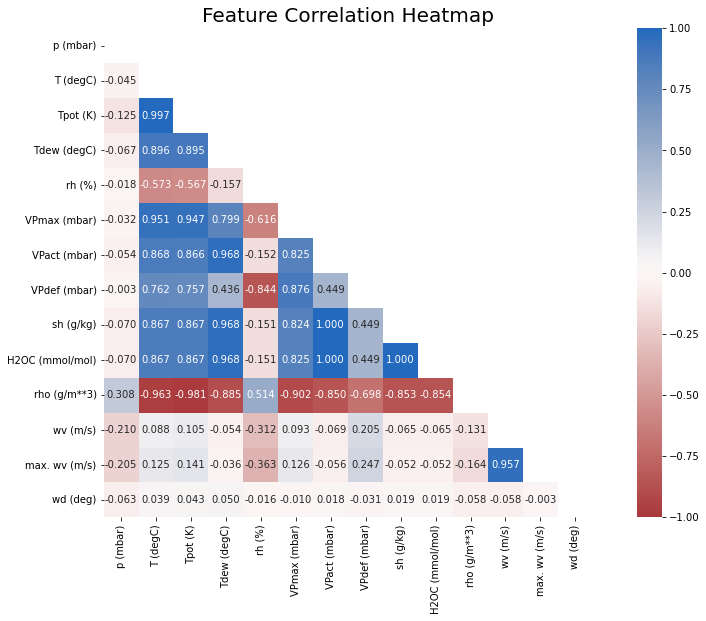

In [5]:
# Get the correlation matrix
feature_corr = df.drop(columns='Date Time').corr()

# mask for upper part of heatmap
trimask = np.triu(np.ones_like(feature_corr, dtype=bool))

# Make our plot
plt.figure(figsize = (16,9))
plt.title("Feature Correlation Heatmap",
         fontsize=20)
sns.heatmap(
    feature_corr,
    vmin=-1, vmax=1, center=0,
    cmap = sns.color_palette("vlag_r", as_cmap=True),
    square=True,
    annot=True,
    fmt='.3f',
    mask=trimask
)
plt.show()

Now we can go through and decide what features we want to keep. Since our target is temperature (we'll do degrees celsius), we want to check for variables that might be with high correlations with temperature. Immediately we'll decide against using Tdew and Tpot since they are both measures of temperature and will have too much colinearity with our target variable (which matters since what we're doing is auto-regressive). We also want to chose one of the vapor pressures since they are colinear with eachother. In our case we'll chose VPmax since it is highly correlated with our target. We'll remove sh and H2OC for similar reasons. We'll remove everything to do with windspeed as it does not appear to have any correlation with our target variable. Note just because we don't have a correlation does not mean there is no meaningful relationship with our target variable, only no meaningful linear relationship.

So we'll be left with the variables:
- T (degC) (our target variable)
- rh (%)
- VPmax (mbar)
- rho (g/m**3)

Now we can remove those columns from our dataframe. We'll also rename the columns to be easier to work with.

In [6]:
df = df[['Date Time','T (degC)','rh (%)', 'VPmax (mbar)', 'rho (g/m**3)']]
df.rename(columns={
    'Date Time':'timestamp',
    'T (degC)':'temperature',
    'rh (%)':'humidity',
    'VPmax (mbar)':'pressure',
    'rho (g/m**3)':'density'
    },
          inplace=True)

### Understanding our feature distributions
Before we move onto more advanced analysis(fourier transformations) let's check to see what our data distributions is for our current variables. First let's see what our data looks like.

In [7]:
df.tail()

,timestamp,temperature,humidity,pressure,density
420446,31.12.2016 23:20:00,-4.05,73.10,4.52,1292.98
420447,31.12.2016 23:30:00,-3.35,69.71,4.77,1289.44
420448,31.12.2016 23:40:00,-3.16,67.91,4.84,1288.39
420449,31.12.2016 23:50:00,-4.23,71.80,4.46,1293.56
420450,01.01.2017 00:00:00,-4.82,75.70,4.27,1296.38


We see that our timestamp is still a column, we need to convert it to a datetime object first before we can do anything with it.

In [8]:
df.loc[:,'timestamp'] = pd.to_datetime(df['timestamp'].str.replace('.','-'),dayfirst=True)
df.tail()

C:\Users\sulli\AppData\Local\Temp\ipykernel_21156\1989922857.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df.loc[:,'timestamp'] = pd.to_datetime(df['timestamp'].str.replace('.','-'),dayfirst=True)


,timestamp,temperature,humidity,pressure,density
420446,2016-12-31 23:20:00,-4.05,73.10,4.52,1292.98
420447,2016-12-31 23:30:00,-3.35,69.71,4.77,1289.44
420448,2016-12-31 23:40:00,-3.16,67.91,4.84,1288.39
420449,2016-12-31 23:50:00,-4.23,71.80,4.46,1293.56
420450,2017-01-01 00:00:00,-4.82,75.70,4.27,1296.38


Cool! Looking at the the tail we see that there is an apparent 10 minute delta between records. Let's make sure that this is always the case and that we aren't missing any time periods. First we'll sort our dataset by timestamp to ensure that everything is ordered properly.

In [9]:
df.sort_values(by='timestamp',ascending=True,inplace=True)
(df['timestamp'] - np.roll(df['timestamp'],1)).unique()

array([-252460200000000000,        600000000000,       1800000000000,
                         0,       1200000000000,      57600000000000,
            60600000000000,     267600000000000], dtype='timedelta64[ns]')

Unfortuenately it looks like we have missing records. Also we weirdly have records with no time differnce indicating there are duplicated records. Let's remove those records.

In [10]:
df = df.loc[~df.duplicated()]

Now we have no duplicated records, but later down the line we'll need to do some cleaning so that we ensure that we have a full matrix input to our model (to be done in the preprocessing phase).

Let's now check out the distribution of our different features.

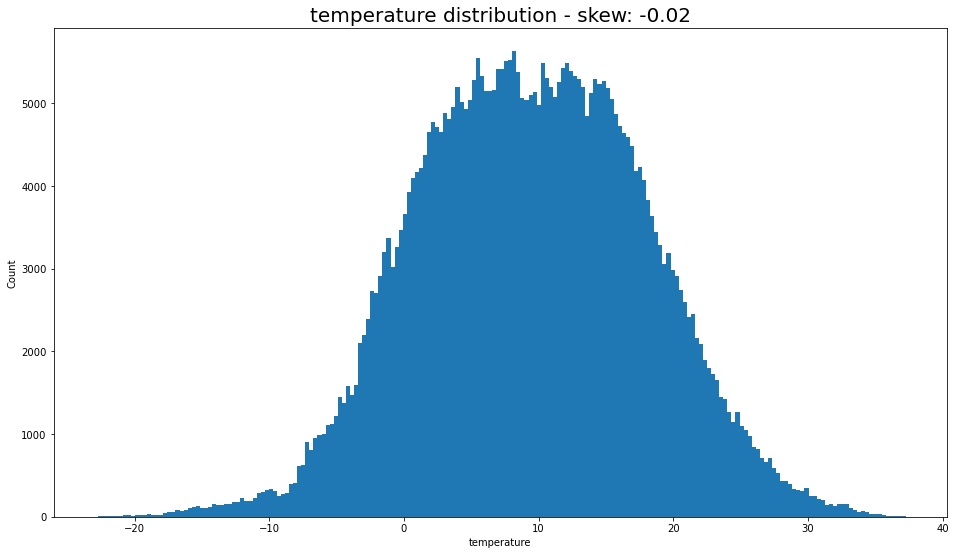

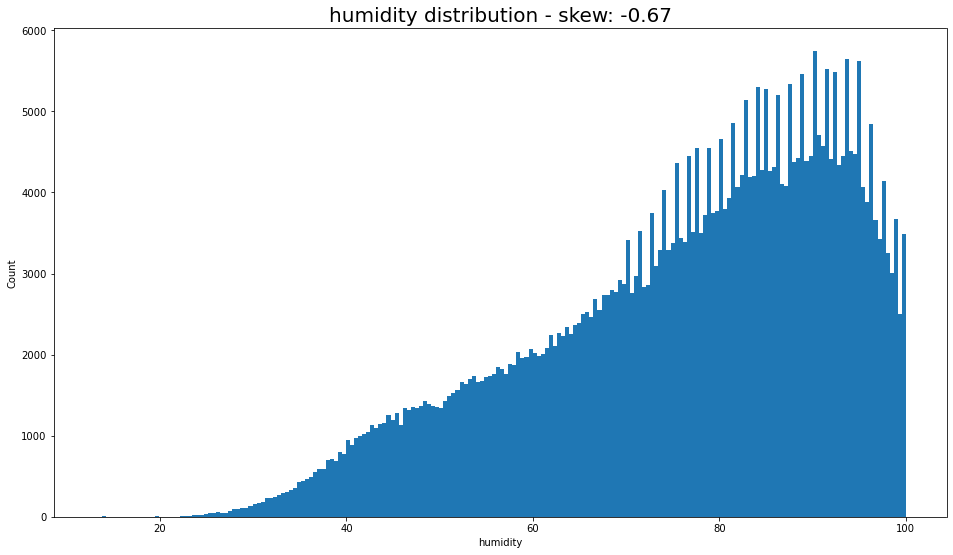

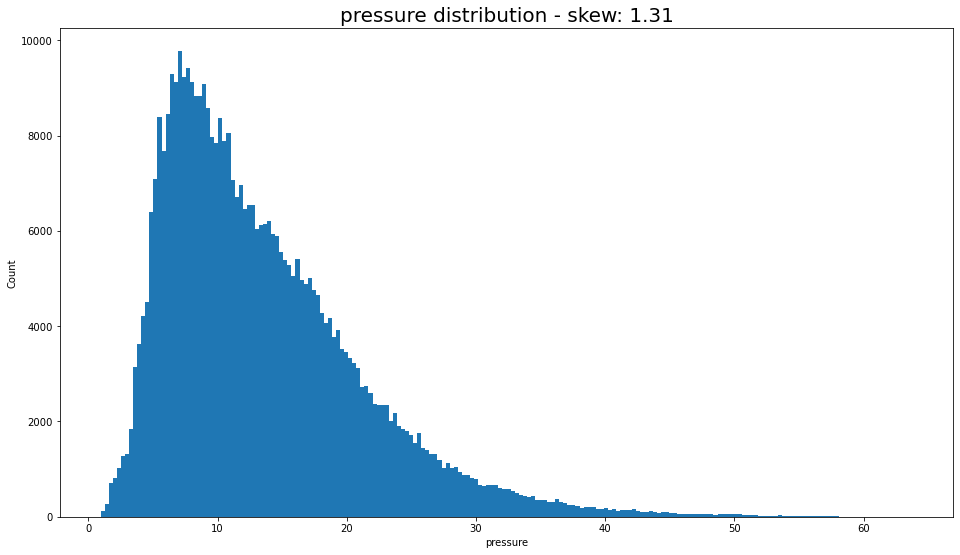

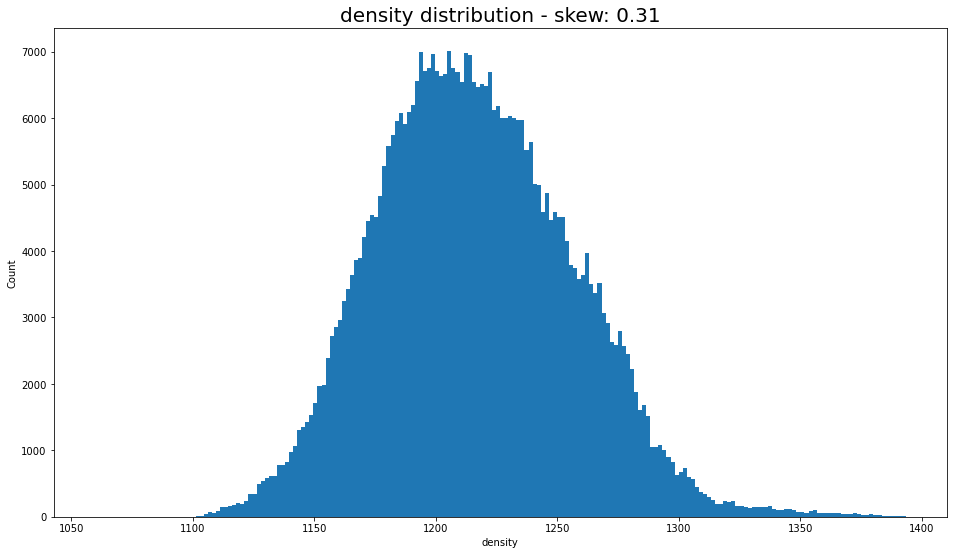

In [11]:
# Parse through all features except datetime
for var in df.columns[1:]:
    plt.figure(figsize=(16,9))
    plt.title(f"{var} distribution - skew: {round(df[var].skew(),2)}",fontsize=20)
    plt.hist(df[var],bins = 200)
    plt.ylabel("Count")
    plt.xlabel(var)
    plt.show()

It looks like our temperature is nice and normally distributed. Density seems to have a moderate skew to it, but this isn't anything too terribly bad. The pressure and humidity distributions are not nearly as nice. Pressure seems to be log normal while humidity is weird. Humidity also has large spikes in data that that do not line up with the rest of the distribution. This could possibly a rounding or data collection error. It could also be due to how we have set up our bins. For now let's look more into pressure distribution.

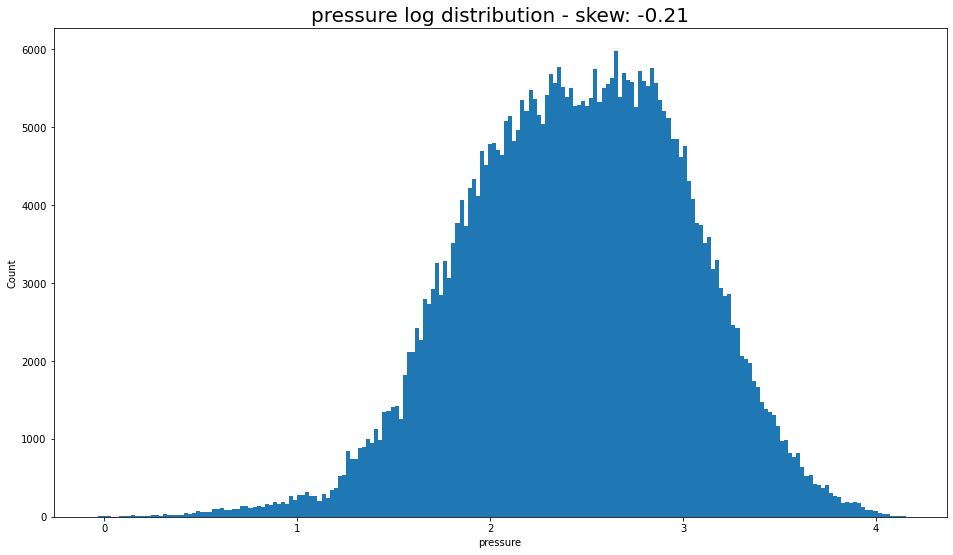

In [12]:
plt.figure(figsize=(16,9))
plt.title(f"pressure log distribution - skew: "
          f"{round(np.log(df['pressure']).skew(),2)}",fontsize=20)
plt.hist(np.log(df['pressure']),bins = 200)
plt.ylabel("Count")
plt.xlabel('pressure')
plt.show()

And if you look at that we have a normal(ish) distribtuion, granted witha moderate skew to it. We should consider transforming this feature by taking its log. Now let's try to tackle how to deal with humidty. We'll first try to square our data.

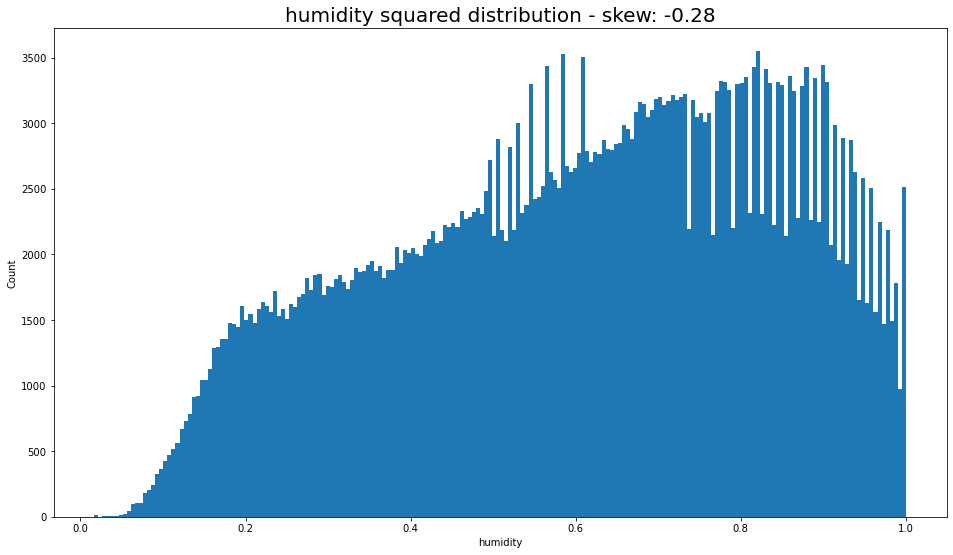

In [13]:
plt.figure(figsize=(16,9))
plt.title(f"humidity squared distribution - skew: "
          f"{round(np.power(df['humidity']/100,2).skew(),2)}",fontsize=20)
plt.hist(np.power(df['humidity']/100,2),bins = 200)
plt.ylabel("Count")
plt.xlabel('humidity')
plt.show()

This doesn't appear to have fixed our issue, let's try some other things. One suggestion of traditional transformation ([from this paper](https://www.iaeng.org/publication/WCE2021/WCE2021_pp101-106.pdf)) for heavily left skewed data is to reflect our data then square root it. Let's try that.

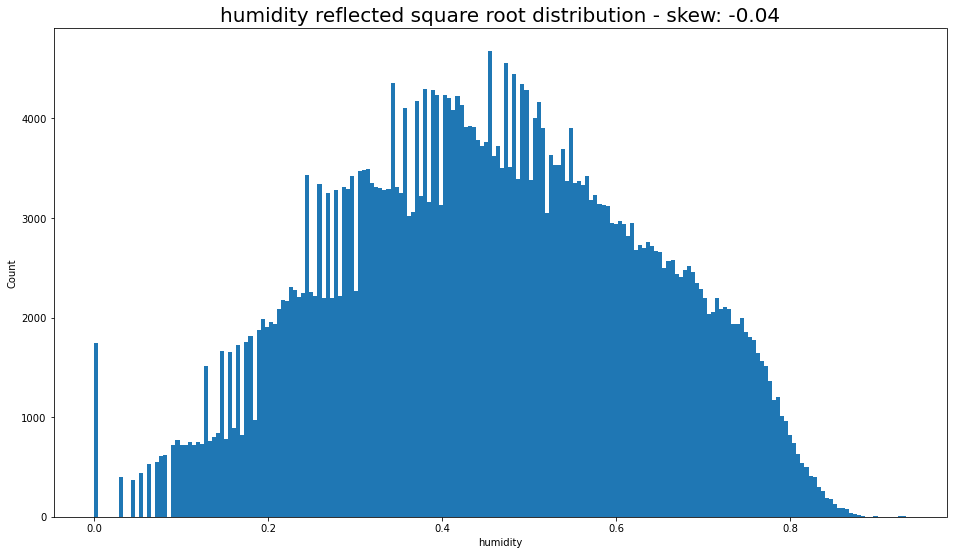

In [14]:
plt.figure(figsize=(16,9))
plt.title(f"humidity reflected square root distribution - skew: "
          f"{round(np.power(1-df['humidity']/100,.5).skew(),2)}",fontsize=20)
plt.hist(np.power(1-df['humidity']/100,.5),bins = 200)
plt.ylabel("Count")
plt.xlabel('humidity')
plt.show()

This is probably as good as we're gona get considering the clear data integrity issue we have. Now let's go through and create a new transformed dataset based on this data. 

In [15]:
df_transformed = df.copy()
df_transformed.loc[:,'humidity'] = np.power(1-df_transformed['humidity']/100,.5)
df_transformed.loc[:,'pressure'] = np.log(df_transformed['pressure'])

Now let's go through and plot our variables vs time to see how things look.

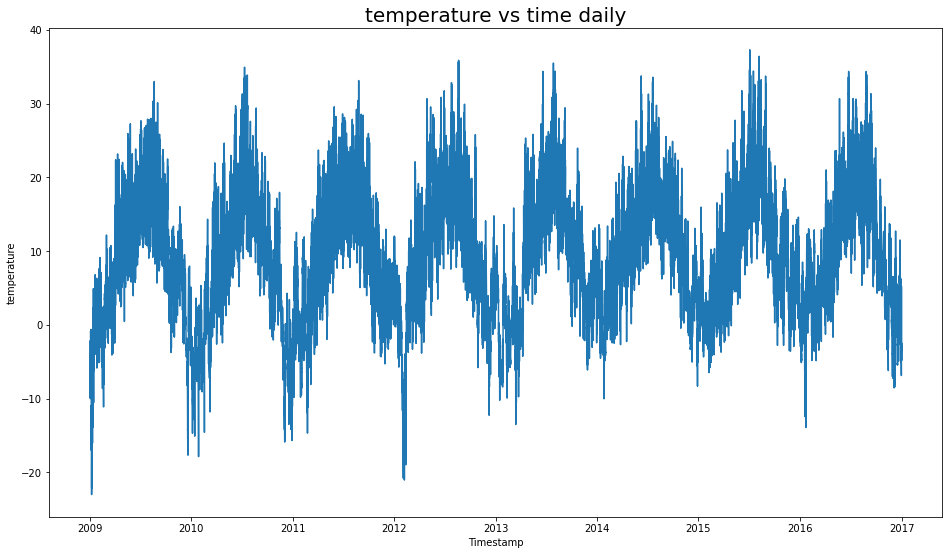

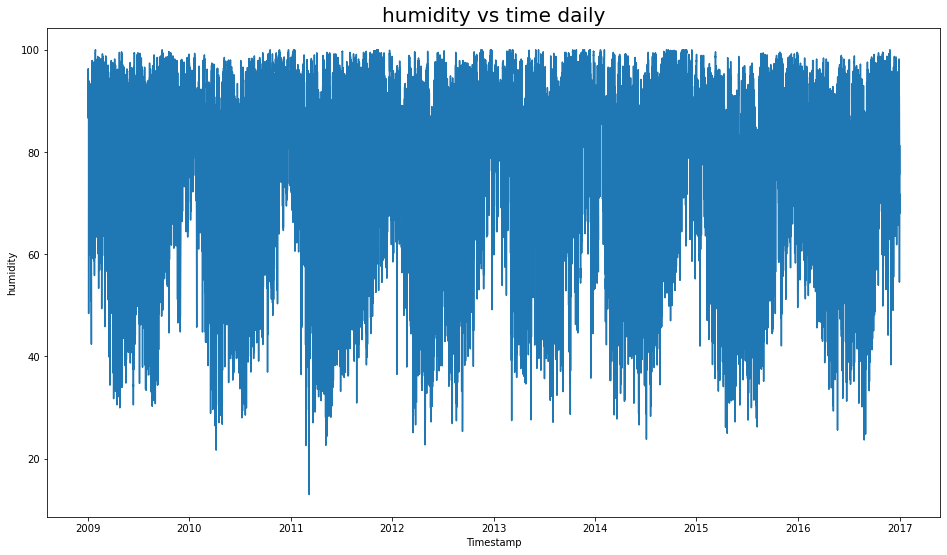

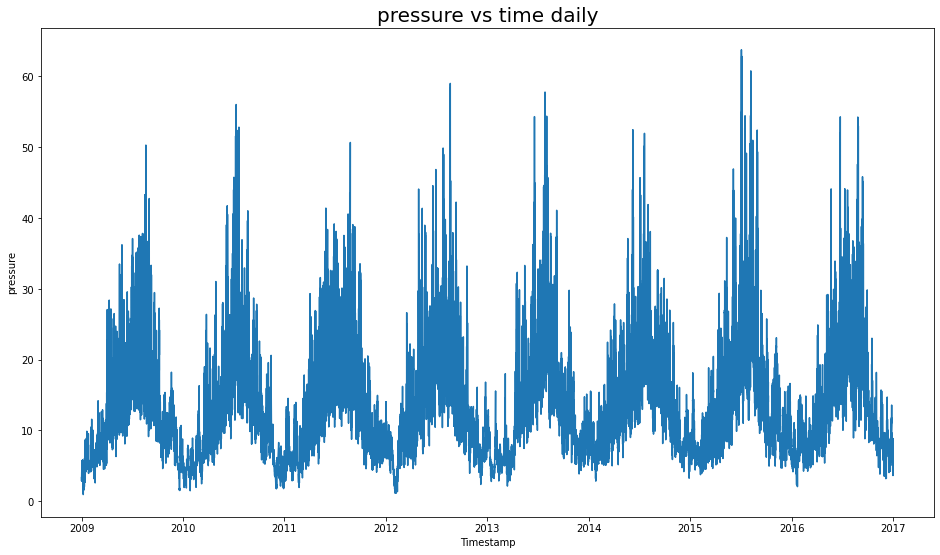

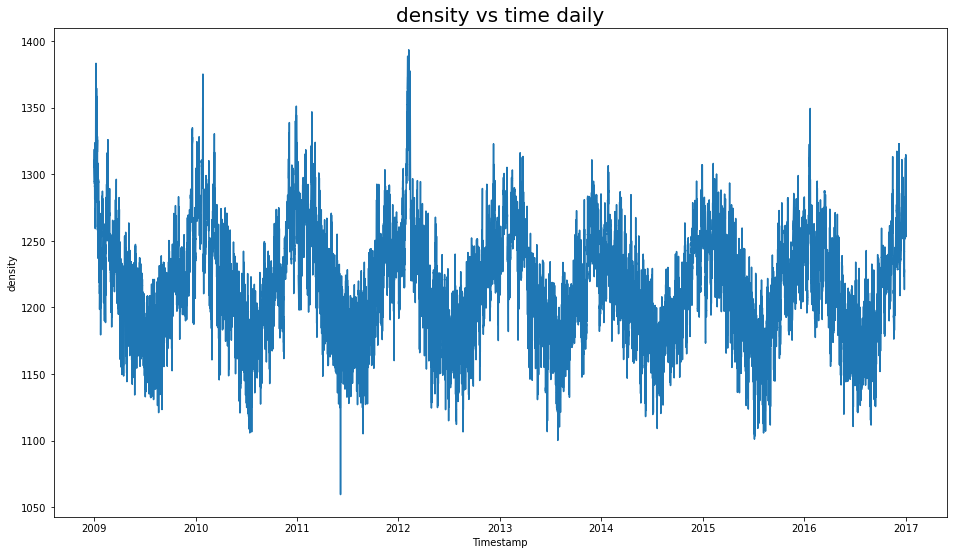

In [16]:
# Parse through all features except datetime
for var in df.columns[1:]:
    plt.figure(figsize=(16,9))
    plt.title(f"{var} vs time daily",fontsize=20)
    plt.plot(df['timestamp'],df[var])
    plt.ylabel(f"{var}")
    plt.xlabel('Timestamp')
    plt.show()

Well we can clearly see that there is a cycle to this data. Let's switch to a daily level of granularity to make things more interpretable.

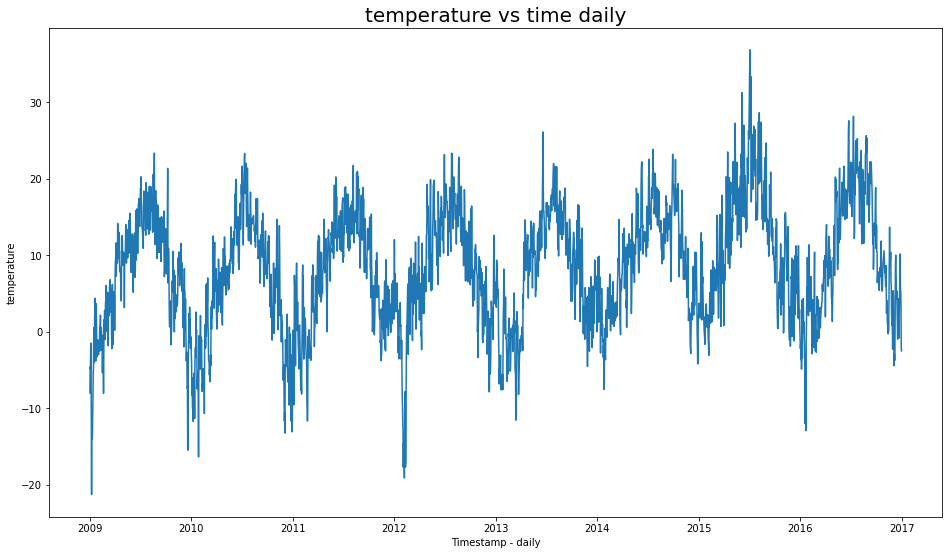

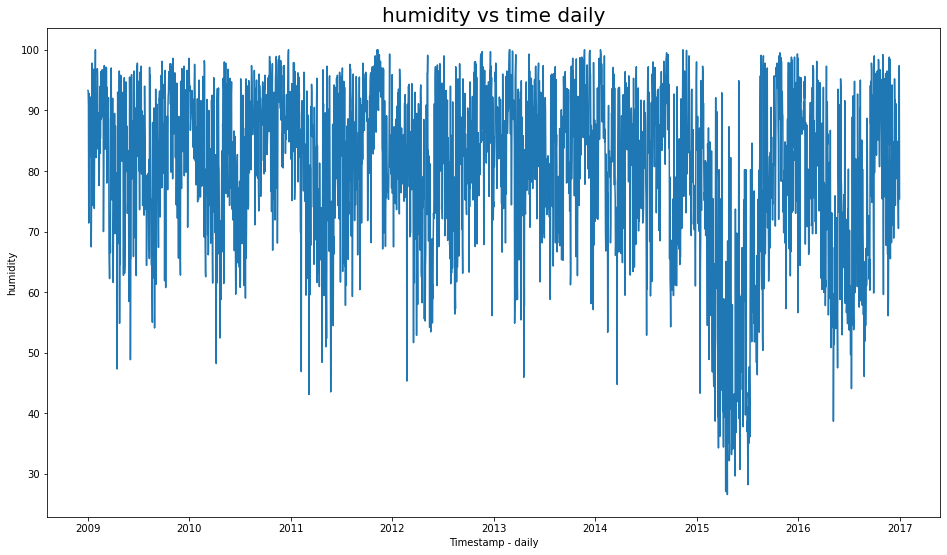

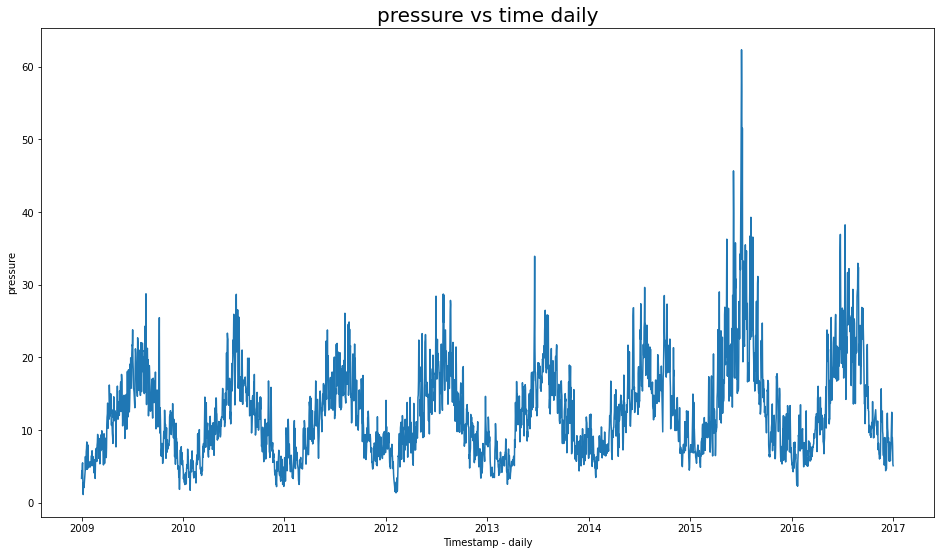

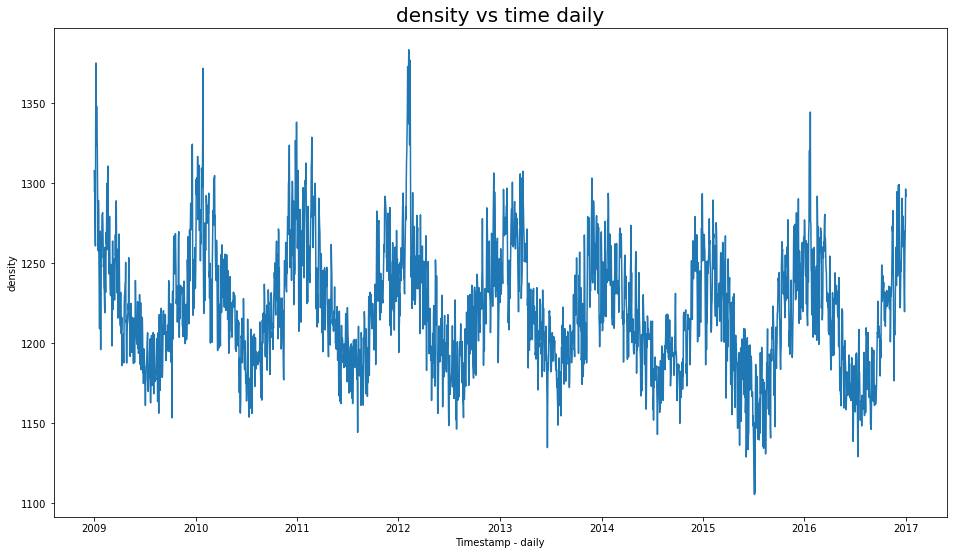

In [17]:
# Parse through all features except datetime
for var in df.columns[1:]:
    plt.figure(figsize=(16,9))
    plt.title(f"{var} vs time daily",fontsize=20)
    plt.plot(df['timestamp'].values[::6*24],df[var].values[::6*24])
    plt.ylabel(f"{var}")
    plt.xlabel('Timestamp - daily')
    plt.show()

Much clearer understanding of the pattern. Notably it looks like our data is shifter at some point in 2015. My guess is that this happens due how we're parsing our daily data and we we skipped some records (one record delta had a 16 hour difference which could've absolutely led to this. Reagardless, let's go through and try to find what our seasonalities are through fourier analysis.

### Fourier Analysis
If you are not familiar with Fourier Transformations, it is a way to decompose a signal into it's base frequencies (at least that's my understanding as to how it works). Importantly, we can extract **seasonality** from our data using Fourier Transformations. For more information on how fourier transformations work, I highly recommend checking out [this video](https://www.youtube.com/watch?v=spUNpyF58BY&list=PLZHQObOWTQDN52m7Y21ePrTbvXkPaWVSg&index=6&ab_channel=3Blue1Brown) from 3Blue1Brown which visualy explains Fourier Transformations. The channel also has some other great videos (included within the playlist) for explaining different mathmatical and computer science concepts. Additionally, it is important to note that the code used for this section of the notebook was inspired by this [Medium article](https://tiofaizintio.medium.com/extract-seasonality-patterns-from-climate-data-with-fast-fourier-transform-fft-de479303f01) by Tio Faizin that goes over extracting seasonailty from climate data.

In [18]:
def do_fourier_transformation(data: pd.DataFrame, variable: str) -> dict:
    """
    Function for doing a fast fourier transformation on a given variable from a dataset and
    returns the magnitude array and period array.

    Parameters
    ----------
    data : pandas dataframe object
    
    variable : column name of the variable being transformed 

    Returns
    -------
    Dictionary containing magnitude and period arrays

    """
    
    # get the length of our data
    n = data.shape[0]
    
    # do fast fourier transformation
    F = fft(np.array(data[variable]))
    
    # do it again in the frequency domain
    w = fftfreq(n,1)
    
    # needed for subsetting
    t = np.linspace(1,n,n)
    
    # subset our array
    T = n/t[0:(n//2)]
    
    # subset only on positive freq
    indices = np.where(w>0)
    
    # get our magnitude
    F_pos = abs(F[indices])
    
    # create our return dict
    return_dict = {
        'magnitude':F_pos,
        'period':T[0:F_pos.shape[0]]
        }
    
    return return_dict

Loop through variables and plot the fourier analysis.

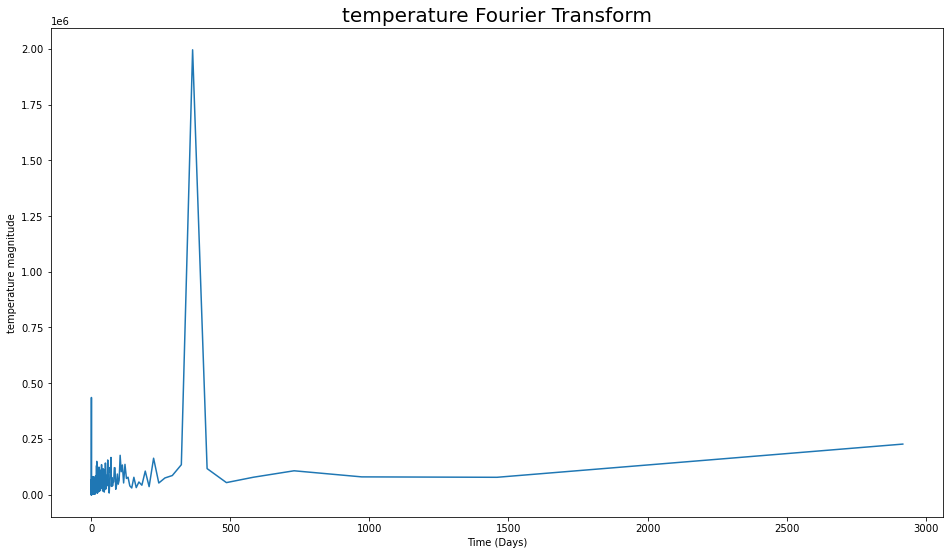

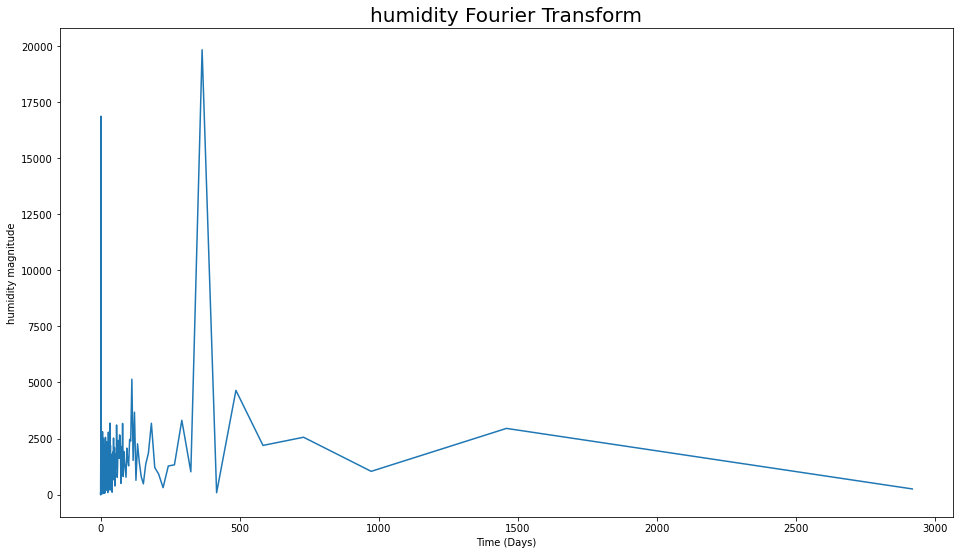

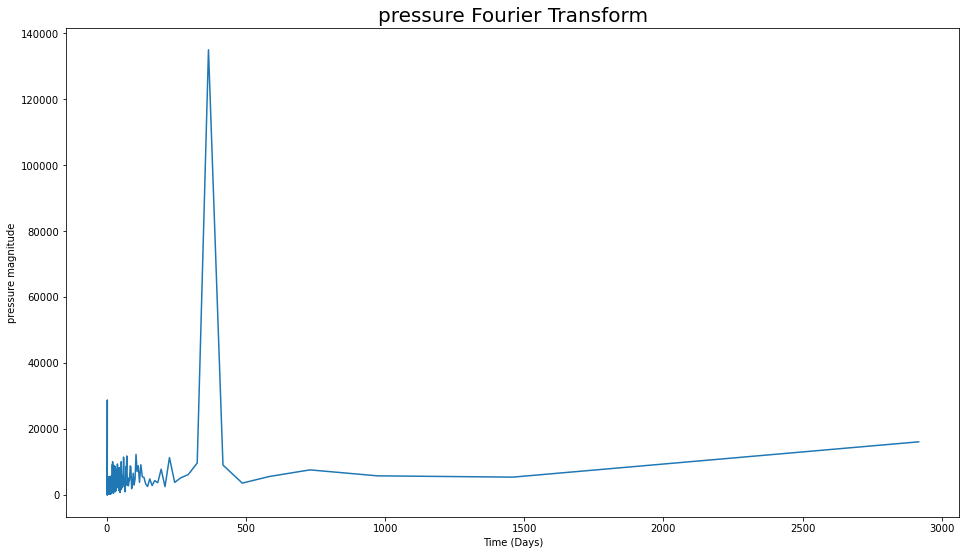

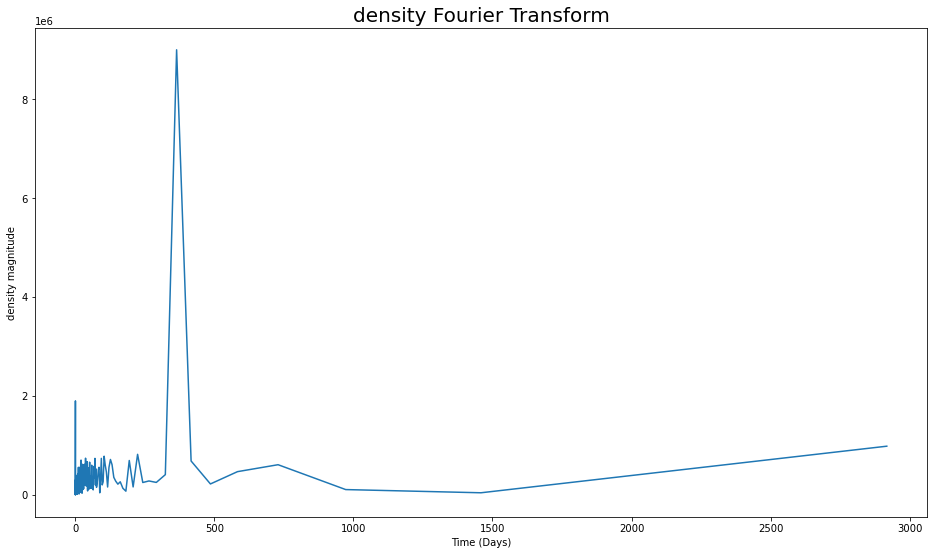

In [19]:
# Create our fourier dictionary
fourier_dfs = {}

# ignore timestamp column
for var in df.columns[1:]:
    # Get our fourier transformation
    fourier_dfs[var] = pd.DataFrame(do_fourier_transformation(df_transformed,var))

    # Change our period column to be in terms of days (div by 6*24)
    fourier_dfs[var]['period'] /= (6*24)
    
    plt.figure(figsize=(16,9))
    plt.title(f"{var} Fourier Transform",fontsize=20)
    plt.plot(fourier_dfs[var]['period'], fourier_dfs[var]['magnitude'])
    plt.ylabel(f'{var} magnitude')
    plt.xlabel('Time (Days)')
    plt.show()

We see two clear spikes in seasonality. My immediate guess is that this is the daily and yearly seasonal patterns in play, but we should verify first. Let's check what the top 5 magnitude is for each variable.

In [20]:
for var in df.columns[1:]:
    print(f"The top 5 seasonal times for {var} are:\n",
         fourier_dfs[var].sort_values(by='magnitude',ascending=False).head(),
         '\n')

The top 5 seasonal times for temperature are:
          magnitude       period
7     1.995504e+06   364.690972
2917  4.355385e+05     0.999838
2916  3.724262e+05     1.000181
0     2.264416e+05  2917.527778
27    1.760614e+05   104.197421 

The top 5 seasonal times for humidity are:
          magnitude      period
7     19838.123796  364.690972
2917  16875.496315    0.999838
2916  14341.532055    1.000181
2914   5689.761708    1.000867
2915   5627.337554    1.000524 

The top 5 seasonal times for pressure are:
           magnitude       period
7     134949.288413   364.690972
2917   28696.026816     0.999838
2916   24759.835954     1.000181
0      16000.309362  2917.527778
27     12189.926332   104.197421 

The top 5 seasonal times for density are:
          magnitude       period
7     8.996471e+06   364.690972
2917  1.894775e+06     0.999838
2916  1.637341e+06     1.000181
0     9.783352e+05  2917.527778
12    8.137296e+05   224.425214 



So we can confirm that there is a yearly and daily seasonality component to this data. What this means to us is that we want to have enough information for at least our daily seasonality. We can figure out a better way to tackle the yearly seasonality later.

## Data Prep
We've now set up a little bit of our data cleaning, but we need to do a lot more leg work now to convert our data into something a sequence neural network can read.

### Dynamic Scaling
We'll also need to scale our data. In this case I'm going to dynamically scale our data week over week using standard scaling. The reason we do this beacuse the **daily trend change** over time, so scaling week over week allows us to learn the paterns in the context of the last few weeks.

In [21]:
def dynamic_scaling(df: pd.DataFrame, features: list, how='standard',**kwargs) -> pd.DataFrame:
    """
    Function for doing dynamic scaling on a dataframe. Returns a copy of the 
    dataframe that has been dynamically standard scaled.

    Parameters
    ----------
    data : pandas dataframe object
    
    features : list of the column names being transformed

    how : the type of scaling to perform. either standard or min_max

    kwargs : key word arguments

    Returns
    -------
    Copy of dataframe with data scaled and information that was used to scale the data

    """
    # Our additional arguments
    args = {
        'num_records':6*24*7,
        'lower_quantile':.01,
        'upper_quantile':.99
    }
    
    # Loop through our kwargs and overwrite default value
    for key, value in kwargs.items():
        args[key] = value

    # Create a copy of our dataframe
    df_scaled = df.copy()
    
    # Now we go through our features and do scaling
    for feature in features:

        # Determine if we're doing standard scaling or min_max
        if how == 'standard':
            # Get the rolling mean
            df_scaled[f"{feature}_mean"] = df_scaled[feature].rolling(args['num_records']).mean()

            # Get the rolling std
            df_scaled[f"{feature}_std"] = df_scaled[feature].rolling(args['num_records']).std()

            # Apply standard scaling
            df_scaled.loc[:,feature] = (df_scaled[feature]-df_scaled[f"{feature}_mean"])/df_scaled[f"{feature}_std"]

        elif how == 'min_max':
            # Get the rolling lower quantile
            df_scaled[f"{feature}_min"] = df_scaled[feature].rolling(args['num_records']).quantile(args['lower_quantile'])

            # Get the upper quantile
            df_scaled[f"{feature}_max"] = df_scaled[feature].rolling(args['num_records']).quantile(args['upper_quantile'])

            # Apply min-max scaling
            df_scaled.loc[:,feature] = (df_scaled[feature] - df_scaled[f"{feature}_min"])/(df_scaled[f"{feature}_max"] - df_scaled[f"{feature}_min"])

        else:
            print("Scaling must be either 'standard' or 'min_max'")
            return None

    # remove our nans
    df_scaled.dropna(inplace=True)   
    
    return df_scaled

Let's see what this looks like for our transformed dataframe. We can compare it to our unscaled data.

In [22]:
df_scaled = dynamic_scaling(df_transformed,df_transformed.columns[1:],how='standard')
df_transformed.merge(df_scaled,how='inner',on='timestamp').describe()

,temperature_x,humidity_x,pressure_x,density_x,temperature_y,humidity_y,pressure_y,density_y,temperature_mean,temperature_std,humidity_mean,humidity_std,pressure_mean,pressure_std,density_mean,density_std
count,419117.000000,419117.000000,419117.000000,419117.000000,419117.000000,419117.000000,419117.000000,419117.000000,419117.000000,419117.000000,419117.000000,419117.000000,419117.000000,419117.000000,419117.000000,419117.000000
mean,9.481807,0.456578,2.454755,1215.891990,-0.007376,-0.001366,-0.012240,0.014865,9.468722,3.799723,0.456556,0.145242,2.453751,0.254297,1215.934918,19.430065
std,8.384678,0.177512,0.567481,39.748203,1.181663,1.084289,1.180396,1.197344,7.424355,1.073639,0.096944,0.032079,0.505042,0.067751,34.412584,5.155348
min,-21.040000,0.000000,0.122218,1059.450000,-4.167725,-4.044070,-4.290705,-5.346875,-14.327857,0.787015,0.143949,0.043243,0.692429,0.058645,1145.728323,5.305758
25%,3.400000,0.325576,2.054124,1187.470000,-0.870360,-0.797942,-0.869371,-0.812049,4.006071,3.011721,0.388214,0.123745,2.093647,0.206847,1187.744474,16.020970
50%,9.430000,0.456070,2.470639,1213.720000,-0.075688,0.051667,-0.060387,0.037973,9.648770,3.756552,0.461390,0.146831,2.480588,0.251444,1212.705605,19.143351
75%,15.480000,0.589915,2.868467,1242.560000,0.814349,0.827799,0.819798,0.878808,15.535238,4.571196,0.527115,0.169190,2.868450,0.300166,1239.939603,22.611154
max,37.280000,0.933006,4.155283,1393.540000,6.229960,4.301752,6.082896,4.100174,25.489018,7.573474,0.678138,0.239803,3.478548,0.584652,1355.372024,48.227429


It looks like we definetly have some outliers within our data. Let's check to see how many records we have where that is the case.

In [23]:
df_scaled.loc[(np.abs(df_scaled['temperature']) >3)|
                (np.abs(df_scaled['humidity']) >3)|
                (np.abs(df_scaled['pressure']) >3)|
                (np.abs(df_scaled['density']) >3)]

,timestamp,temperature,humidity,pressure,density,temperature_mean,temperature_std,humidity_mean,humidity_std,pressure_mean,pressure_std,density_mean,density_std
1534,2009-01-11 15:50:00,1.912832,3.064795,1.845551,-1.455901,-10.803829,5.580119,0.376272,0.088105,0.972199,0.448570,1324.943730,31.577512
1663,2009-01-12 13:20:00,2.450858,3.026573,2.333322,-2.646273,-11.501885,4.803169,0.388800,0.090755,0.918817,0.390241,1330.987857,23.401917
1664,2009-01-12 13:30:00,2.538120,3.125800,2.408902,-2.737805,-11.496835,4.813340,0.389111,0.091194,0.919189,0.390961,1330.972321,23.439333
1665,2009-01-12 13:40:00,2.646849,3.217948,2.507731,-2.855924,-11.491151,4.825039,0.389439,0.091660,0.919609,0.391788,1330.953433,23.485721
1666,2009-01-12 13:50:00,2.676156,3.238967,2.535076,-2.893216,-11.485238,4.837251,0.389785,0.092128,0.920046,0.392653,1330.933254,23.535493
...,...,...,...,...,...,...,...,...,...,...,...,...,...
420212,2016-12-30 08:20:00,-2.960313,-1.995653,-3.033124,2.515644,4.643730,3.112417,0.411785,0.109955,2.138814,0.220446,1256.939365,21.040592
420213,2016-12-30 08:30:00,-2.926537,-1.993162,-3.000049,2.496778,4.638929,3.122779,0.411723,0.110061,2.138458,0.221228,1256.967579,21.092148
420216,2016-12-30 09:00:00,-2.945306,-1.919749,-3.016816,2.526335,4.625317,3.152582,0.411626,0.110236,2.137447,0.223478,1257.049762,21.244308
420217,2016-12-30 09:10:00,-2.993739,-1.830837,-3.076907,2.560753,4.620446,3.163417,0.411617,0.110253,2.137082,0.224304,1257.078819,21.298881


Looks like only 6.4k (or **1.5%**) of our data has outliers when doing this method. I think to make things simple we'll include this data in our model.

Lastly let's get our baseline for this MSE

In [24]:
from sklearn.metrics import mean_squared_error
round(mean_squared_error(df['temperature'],np.roll(df['temperature'],6*24)),3)

11.591

### Transforming Data Into Sequences
We need have our target be a scalar, and our input be a matrix of n x m where n is the number of previous records we want to include in our input and m is the number of features we have.

In [25]:
def create_seq_data(df: pd.DataFrame, features: list, target: str, **kwargs) -> tuple:
    """
    Function for creating creating our X and y arrays. X will be 

    Parameters
    ----------
    data : pandas dataframe object
    
    features : list of the column names being transformed

    target : the column name of our target column

    kwargs : key word arguments

    Returns
    -------
    tuple of X and y

    """

    # Our additional arguments
    args = {
        'slice_window':6*24,
        'iterator':1,
        'k':6*24
    }

    # Loop through our kwargs and overwrite default value
    for key, value in kwargs.items():
        args[key] = value

    # cast our dataframe to a numpy array
    df_arr = np.array(df[features])

    # find what column our target is
    target_col = list(df[features].columns).index(target)
    
    # assign our first value (so that we can np.append to it)
    X = []
    y = []
    
    # Oh boy here we have to create the most complex part of our program,
    # creating our X and y arrays. Looping :(
    for i in range(args['slice_window']+args['k'],df_arr.shape[0]+1):

        # Get our temp x
        temp_X = np.array(df_arr[i-args['slice_window'] - args['k']-1+args['iterator']
                          :i-args['k']:args['iterator'],:])

        # Get our temp y
        temp_y = np.array([df_arr[i-1,target_col]])

        X.append(temp_X)
        y.append(temp_y)

    # Cast to numpy array
    X = np.array(X)
    y = np.array(y)

    # Create and return a function that unscales a record given an index
    def unscale_data(array: np.array, index_range: tuple) -> np.array:
        """
        Function for unscaling data from create_seq_data

        Parameters
        ----------
        array: target array to be unscaled
    
        index_range: tuple of starting and end index to 

        Returns
        -------
        tuple of X and y
        """

        # We'll check if we have a start index. If we do we add the slice window
        if index_range[0]:
            start_index = args['slice_window'] + args['k'] -1  + index_range[0]
        # Else we just start at the slice indow
        else:
            start_index = args['slice_window'] + args['k'] -1

        if index_range[1]:
            end_index = args['slice_window'] + args['k'] + index_range[1]
        else:
            end_index = None

        # Now let's check what method of scaling we did, we'll check for target mean column
        if f"{target}_mean" in df.columns:
            
            # Get our mean and std to unscale
            target_mean = np.array(df.iloc[start_index:end_index:args['iterator']][f"{target}_mean"])
            target_std = np.array(df.iloc[start_index:end_index:args['iterator']][f"{target}_std"])

            # Now unscale the array
            unscaled = (array * target_std) + target_mean

        # Otherwise we're min - max scaling
        else:
            # Get our min and max to unscale
            target_max = np.array(df.iloc[start_index:end_index:args['iterator']][f"{target}_max"])
            target_min = np.array(df.iloc[start_index:end_index:args['iterator']][f"{target}_min"])           
        
            # Now unscale the array
            unscaled = array*(target_max - target_min) + target_min

        return np.round(unscaled, decimals=2)
    
    return X, y, unscale_data

We should now have the ability to create our matrix. Let's assign it to X and y and see what they look like.

In [26]:
X, y, unscale_data = create_seq_data(df_scaled, df_scaled.columns[1:],'temperature')
print(f"X has the shape:\n\t{X.shape}\n")
print(f"y has the shape:\n\t{y.shape}")

X has the shape:
	(418830, 144, 12)

y has the shape:
	(418830, 1)


Let's make sure that our MSE is similar to the baseline we set before. This helps us ensure that our function is properly working.

In [27]:
round(mean_squared_error(
    unscale_data(X[:,-1,0],(None,None)),
    unscale_data(y[:,0],(None,None))),
    3)

11.961

This looks roughly the same, let's make sure that we also have the same values when we unscale our data.

In [28]:
print(f"Last 5 records unscaled from y:\n\t{list(unscale_data(y[-5:,0],(y.shape[0]-5,None)))}")
print(f"Last 5 records from original data:\n\t{list(df['temperature'].tail())}")

Last 5 records unscaled from y:
	[-4.05, -3.35, -3.16, -4.23, -4.82]
Last 5 records from original data:
	[-4.05, -3.35, -3.16, -4.23, -4.82]


Looks like everything is working properly then! We can now seperate our training and test set. Remember that for time series data we do not split our training and test set randomly, instead we split it based on past and future. We'll chose a **80-10-10 train validation test split** for our data.

In [29]:
train_cutoff = round(X.shape[0]*.8)
val_cutoff = round(X.shape[0]*.9)
X_train, X_val, X_test = X[:train_cutoff,:,:], X[train_cutoff:val_cutoff,:,:], X[val_cutoff:,:,:]
y_train, y_val, y_test = y[:train_cutoff,:], y[train_cutoff:val_cutoff,:], y[val_cutoff:,:]

Let's check the shape of our data.

In [30]:
print(f"X_train has the shape:\n\t{X_train.shape}\n")
print(f"X_val has the shape:\n\t{X_val.shape}\n")
print(f"X_test has the shape:\n\t{X_test.shape}\n")
print(f"y_train has the shape:\n\t{y_train.shape}\n")
print(f"y_val has the shape:\n\t{y_val.shape}\n")
print(f"y_test has the shape:\n\t{y_test.shape}")

X_train has the shape:
	(335064, 144, 12)

X_val has the shape:
	(41883, 144, 12)

X_test has the shape:
	(41883, 144, 12)

y_train has the shape:
	(335064, 1)

y_val has the shape:
	(41883, 1)

y_test has the shape:
	(41883, 1)


Lastly let's get the MSE of our test set specifically. Our goal is to beat this MSE.

In [33]:
round(mean_squared_error(
    unscale_data(X_test[:,-1,0],(val_cutoff,None)),
    unscale_data(y_test[:,0],(val_cutoff,None))),
      3)

10.053

Our goal is now set: **get less than 10.053 MSE**

## Modeling

### Setting Up Torch
Before we get into any modeling, let's setup our environment and data for pytorch. First let's get our packages and set up our device.

In [34]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm

# Set up our device
device = 'cuda' if torch.cuda.is_available() else 'cpu'

ModuleNotFoundError: No module named 'torch'

We'll create a custom dataset for our dataset so that way we easily batch our data for training.

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, x_data, y_data):
        # Convert numpy arrays to tensors
        self.x_data = torch.from_numpy(x_data).float()
        self.y_data = torch.from_numpy(y_data).float()

    def __len__(self):
        return len(self.x_data)

    def __getitem__(self, idx):
        return self.x_data[idx], self.y_data[idx]


# dataset instances
train_dataset = CustomDataset(X_train, y_train)
val_dataset = CustomDataset(X_val, y_val)
test_dataset = CustomDataset(X_test, y_test)

# dataloaders
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### Creating General Model Functions
We'll use common functions that will be done outside of an individual model. These functions are taken directly from the [pytorch quickstart guide](https://pytorch.org/tutorials/beginner/basics/quickstart_tutorial.html), modified to fit our regression problem.

First let's build our train function.

In [ ]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    # Progress bar
    loop = tqdm(dataloader)

    # Loop through batches 
    for batch, (X, y) in enumerate(loop):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # Add to the progress bar
        loop.set_postfix(loss=loss.item())

As well as our test function.

In [ ]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
    test_loss /= num_batches
    print(f"Val Error: \n Avg loss: {test_loss:>8f} \n")

Finally let's assign our loss function.

In [ ]:
loss_fn = nn.MSELoss()

### LSTM 
Our first go around at this problem will be to use a LSTM neural network. Our architecture is going to be very simple:
    
    input->LSTM->LSTM->dropout->MLP->output

Now let's build our LSTM model class.

In [ ]:
class LSTM(nn.Module):
    
    def __init__(self, input_size, hidden_size, num_stacked_layers,mlp_size):
        super().__init__()

        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.mlp_size = mlp_size
        
        # Create our LSTM 
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                                batch_first=True,dropout=.2)
        self.MLP = nn.Linear(hidden_size,mlp_size)
        self.elu = nn.ELU()
        self.final = nn.Linear(mlp_size,1)

    def forward(self,X):
        # get our batch size for this input
        batch_size = X.size(0)

        # we need to pass our init hidden and cell states
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(X, (h0,c0))

        # pass the final output of LSTM to MLP 
        out = self.elu(self.MLP(out[:,-1,:]))

        # final outut
        out = self.final(out)

        return out

Cool, let's now build our model and optimizer.

In [ ]:
# Create model
my_lstm = LSTM(4,48,4,48)
my_lstm.to(device)
# Create optmizer
learning_rate = .001
optimizer = torch.optim.Adam(my_lstm.parameters(), lr=learning_rate)

Let's now train our model! We'll train it for 5 epochs.

In [ ]:
epochs = 5
for epoch in range(epochs):
    print(f"Epoch [{epoch+1}/{epochs}]")
    train(train_loader, my_lstm, loss_fn, optimizer)
    test(val_loader, my_lstm, loss_fn)

Success! We were able to get our MSE to below the baseline. We haven't even gotten to our more sophisticated models yet either. Let's go through and visualize how our test predictions performed.

### TO DO

Just for fun, let's see what our model might've performed like if we had unscaled, untransformed data.

In [ ]:
X_raw, y_raw = create_seq_data(df, df.columns[1:],'temperature')
X_train_raw, X_test_raw = X_raw[:record_cutoff,:,:],X_raw[record_cutoff:,:,:]
y_train_raw, y_test_raw = y_raw[:record_cutoff,:], y_raw[record_cutoff:,:]

# make the dataset
train_dataset_raw = CustomDataset(X_train_raw, y_train_raw)
test_dataset_raw = CustomDataset(X_test_raw, y_test_raw)

# and loader
train_loader_raw = DataLoader(train_dataset_raw, batch_size=128, shuffle=True)
test_loader_raw = DataLoader(test_dataset_raw, batch_size=128, shuffle=False)



Now we model it.

In [ ]:
# Create model
my_lstm_2 = LSTM(4,48,4,48)
my_lstm_2.to(device)
# Create optmizer
learning_rate = .001
optimizer_2 = torch.optim.Adam(my_lstm_2.parameters(), lr=learning_rate)

# Training loop
epochs = 5
for epoch in range(epochs):
    print(f"Epoch [{epoch+1}/{epochs}]")
    train(train_loader_raw, my_lstm, loss_fn, optimizer)
    test(test_loader_raw, my_lstm, loss_fn)